<h1><b>Dask</b></h1>

Dask is a flexible library for parallel computing in Python.

Dask was originally developed at Continuum Analytics, a for-profit Python consulting company that eventually became Anaconda Inc, the creator of many open source packages, and the popular Anaconda Python distribution. Dask grew out of the Blaze project, a DARPA funded project to accelerate computation in open source. Initial release: January 8, 2015; 7 years ago

Dask is composed of two parts:
<ul>
    <li>
Dynamic task scheduling optimized for computation. This is similar to Airflow, Luigi, Celery, or Make, but optimized for interactive computational workloads.
    </li>
    <li>
“Big Data” collections like parallel arrays, dataframes, and lists that extend common interfaces like NumPy, Pandas, or Python iterators to larger-than-memory or distributed environments. These parallel collections run on top of dynamic task schedulers.
    </li>
</ul>


Dask emphasizes the following virtues:
<ul>
    <li>
Familiar: Provides parallelized NumPy array and Pandas DataFrame objects
</li>
    <li>
Flexible: Provides a task scheduling interface for more custom workloads and integration with other projects.
</li>
    <li>
Native: Enables distributed computing in pure Python with access to the PyData stack.
</li>
    <li>
Fast: Operates with low overhead, low latency, and minimal serialization necessary for fast numerical algorithms
</li>
    <li>
Scales up: Runs resiliently on clusters with 1000s of cores
</li>
    <li>
Scales down: Trivial to set up and run on a laptop in a single process
</li>
    <li>
Responsive: Designed with interactive computing in mind, it provides rapid feedback and diagnostics to aid humans
       </li>
</ul>
<img src="dask-overview.svg" width="90%">

# Familiar User Interface:

# Dask DataFrame mimics Pandas - [documentation](https://docs.dask.org/en/stable/dataframe.html)

A Dask DataFrame is a large parallel DataFrame composed of many smaller Pandas DataFrames, split along the index. These Pandas DataFrames may live on disk for larger-than-memory computing on a single machine, or on many different machines in a cluster. One Dask DataFrame operation triggers many operations on the constituent Pandas DataFrames.



In [13]:
import pandas as pd                     
df = pd.read_csv('data/accounts.0.csv')      
df.groupby(df.id).amount.mean()    

id
0       514.666667
1      2076.659751
2       558.344272
3       644.715183
4       249.428571
          ...     
495    2069.396916
496    1965.103219
497     464.691765
498      90.948468
499      26.029795
Name: amount, Length: 500, dtype: float64

In [12]:
df.head()

,id,names,amount
0,155,Ingrid,1486
1,450,Laura,628
2,363,Dan,995
3,389,Sarah,-48
4,188,Ray,426


In [14]:
import dask.dataframe as dd
df = dd.read_csv('data/accounts.0.csv')
df.groupby(df.id).amount.mean().compute()

id
0       514.666667
1      2076.659751
2       558.344272
3       644.715183
4       249.428571
          ...     
495    2069.396916
496    1965.103219
497     464.691765
498      90.948468
499      26.029795
Name: amount, Length: 500, dtype: float64

In [15]:
df.head()

,id,names,amount
0,155,Ingrid,1486
1,450,Laura,628
2,363,Dan,995
3,389,Sarah,-48
4,188,Ray,426


# Dask Array mimics NumPy - [documentation](https://docs.dask.org/en/stable/array.html)

Dask Array implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many small arrays. This lets us compute on arrays larger than memory using all of our cores. We coordinate these blocked algorithms using Dask graphs.

In [17]:

import numpy as np 
import h5py
f = h5py.File('data/weather-small/2014-01-01.hdf5')             
x = np.array(f['t2m'])           
                                                           
x - np.array([x.mean(axis=1) for y in range(360)]).T

array([[-3.03194444, -3.03194444, -3.03194444, ..., -3.03194444,
        -3.03194444, -3.03194444],
       [-3.64791667, -3.64791667, -3.64791667, ..., -2.64791667,
        -2.64791667, -3.64791667],
       [ 0.39444444, -0.10555556, -0.10555556, ...,  0.39444444,
         0.39444444,  0.39444444],
       ...,
       [ 2.98611111,  2.98611111,  2.98611111, ...,  3.73611111,
         2.98611111,  2.98611111],
       [ 3.71527778,  3.71527778,  4.21527778, ...,  3.71527778,
         3.71527778,  3.71527778],
       [ 2.05138889,  2.05138889,  2.05138889, ...,  2.30138889,
         2.30138889,  2.30138889]])

In [8]:
f = h5py.File('data/weather-small/2014-01-01.hdf5') 
f['t2m']

<HDF5 dataset "t2m": shape (180, 360), type "<f8">

In [21]:
import dask.array as da
f = h5py.File('data/weather-small/2014-01-01.hdf5')
x = da.from_array(f['t2m'],chunks=(1000, 1000))
z = x - da.from_array([x.mean(axis=1).compute() for y in range(360)]).T
z.compute()

array([[-3.03194444, -3.03194444, -3.03194444, ..., -3.03194444,
        -3.03194444, -3.03194444],
       [-3.64791667, -3.64791667, -3.64791667, ..., -2.64791667,
        -2.64791667, -3.64791667],
       [ 0.39444444, -0.10555556, -0.10555556, ...,  0.39444444,
         0.39444444,  0.39444444],
       ...,
       [ 2.98611111,  2.98611111,  2.98611111, ...,  3.73611111,
         2.98611111,  2.98611111],
       [ 3.71527778,  3.71527778,  4.21527778, ...,  3.71527778,
         3.71527778,  3.71527778],
       [ 2.05138889,  2.05138889,  2.05138889, ...,  2.30138889,
         2.30138889,  2.30138889]])

# Dask Bag mimics iterators, Toolz, and PySpark - [documentation](https://docs.dask.org/en/stable/bag.html)

Common Uses
Dask bags are often used to parallelize simple computations on unstructured or semi-structured data like text data, log files, JSON records, or user defined Python objects.


In [22]:
import dask.bag as db
import json
b = db.read_text('data/accounts.0.csv').str.strip().str.split(',')
b.take(2)

(['id', 'names', 'amount'], ['155', 'Ingrid', '1486'])

In [19]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName(
    'Read CSV File into DataFrame').getOrCreate()
df = spark.read.csv("data/accounts.0.csv")

In [20]:
df.show(2)

+---+------+------+
|_c0|   _c1|   _c2|
+---+------+------+
| id| names|amount|
|155|Ingrid|  1486|
+---+------+------+
only showing top 2 rows



In [17]:
spark.stop()

# PySpark vs Dask - [documentation](https://docs.dask.org/en/stable/spark.html#:~:text=welcome%20any%20corrections.-,Summary,to%20achieve%20high%2Dlevel%20functionality.)

Performance between Dask and Pyspark is equivalent - https://arxiv.org/abs/1907.13030<br>


Summary<br>
Generally Dask is smaller and lighter weight than Spark. This means that it has fewer features and, instead, is used in conjunction with other libraries, particularly those in the numeric Python ecosystem. It couples with libraries like Pandas or Scikit-Learn to achieve high-level functionality.

<h4>Reasons you might choose Spark</h4>
<ul>
    <li>
You prefer Scala or the SQL language
 </li>
    <li>
You have mostly JVM infrastructure and legacy systems
 </li>
    <li>
You want an established and trusted solution for business
 </li>
    <li>
You are mostly doing business analytics with some lightweight machine learning
 </li>
    <li>
You want an all-in-one solution
 </li>
    </ul>
<h4>Reasons you might choose Dask</h4>
<ul>
    <li>
You prefer Python or native code, or have large legacy code bases that you do not want to entirely rewrite
    </li>
    <li>
Your use case is complex or does not cleanly fit the Spark computing model
</li>
    <li>
You want a lighter-weight transition from local computing to cluster computing
</li>
    <li>
You want to interoperate with other technologies and don’t mind installing multiple packages
    </li>
    </ul>
<h4>Conclusion</h4>
Spark is mature and all-inclusive. If you want a single project that does everything and you’re already on Big Data hardware, then Spark is a safe bet, especially if your use cases are typical ETL + SQL and you’re already using Scala.

Dask is lighter weight and is easier to integrate into existing code and hardware. If your problems vary beyond typical ETL + SQL and you want to add flexible parallelism to existing solutions, then Dask may be a good fit, especially if you are already using Python and associated libraries like NumPy and Pandas.

If you are looking to manage a terabyte or less of tabular CSV or JSON data, then you should forget both Spark and Dask and use Postgres or MongoDB.

[Towards data science comparison pyspark and other alternatives including Dask](https://towardsdatascience.com/beyond-pandas-spark-dask-vaex-and-other-big-data-technologies-battling-head-to-head-a453a1f8cc13)
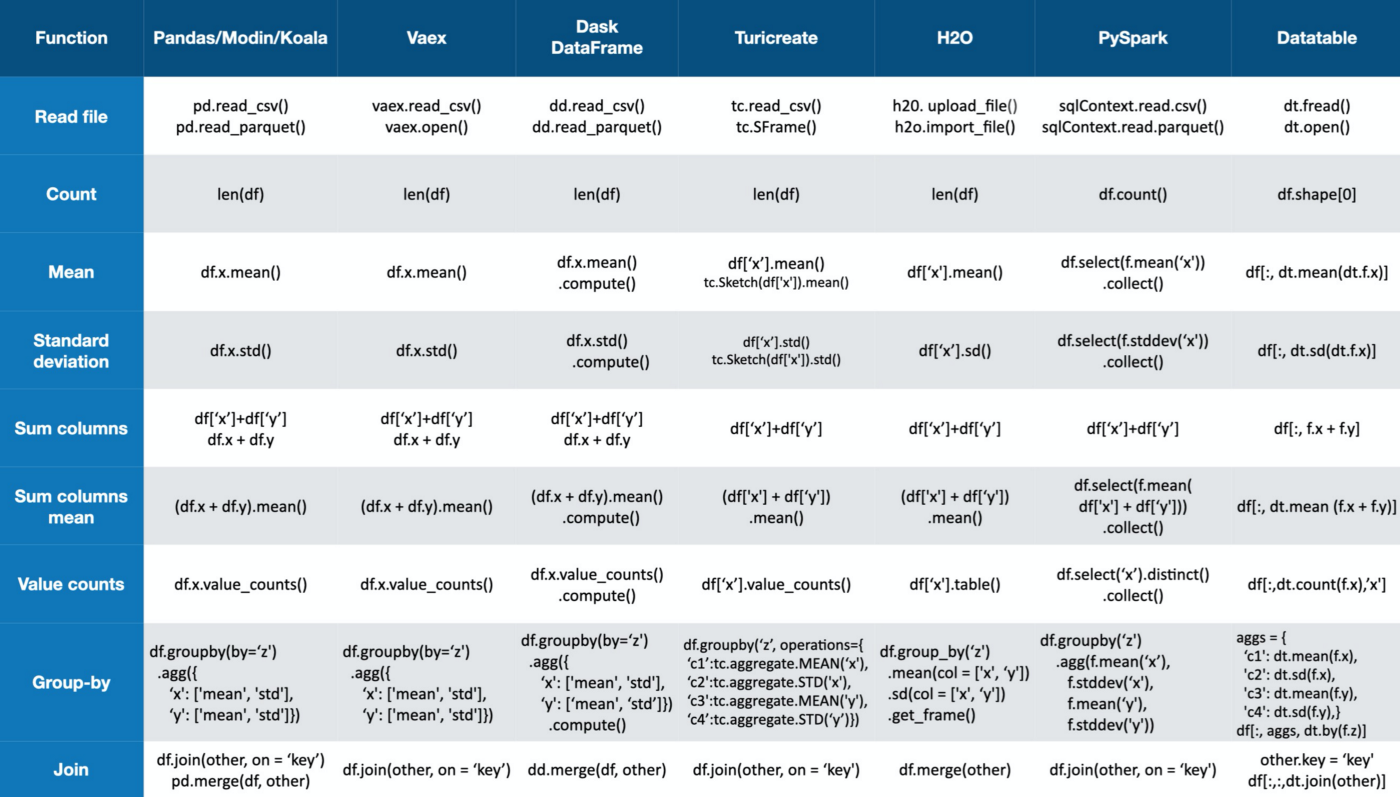

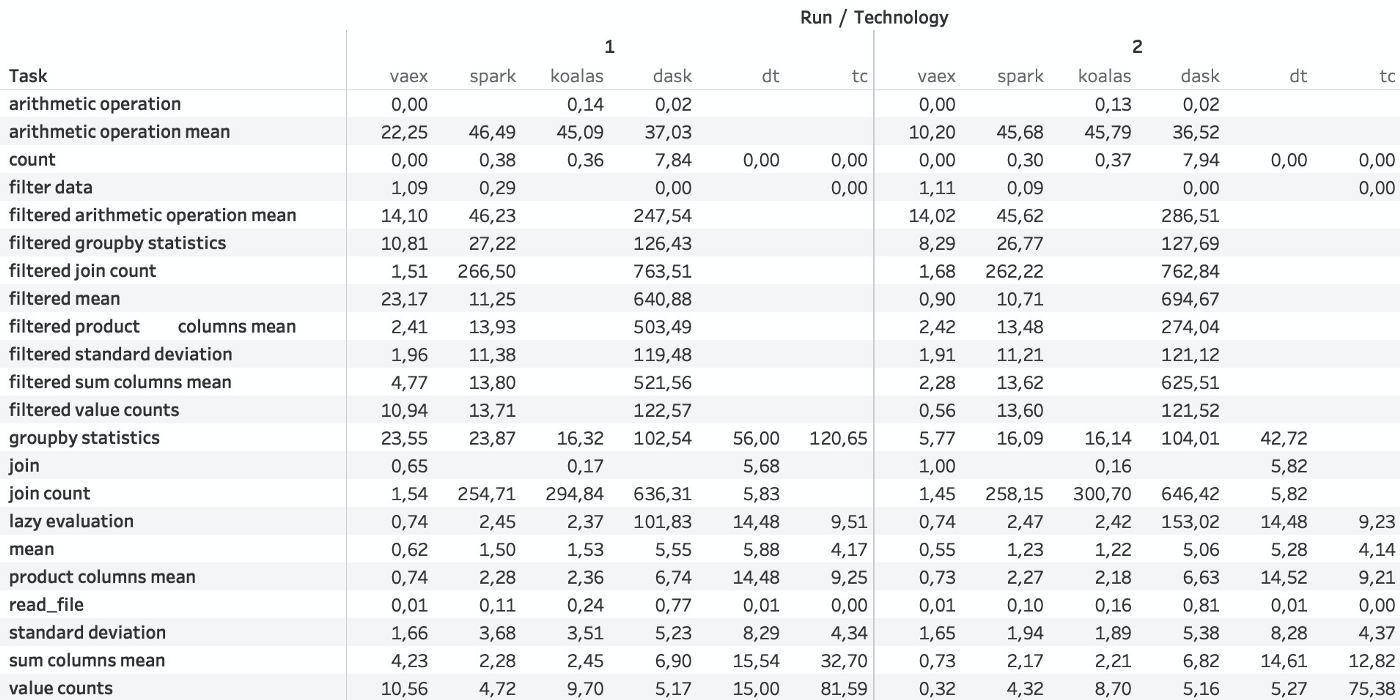

# Dask Delayed mimics for loops and wraps custom code - [documentation](https://docs.dask.org/en/stable/delayed.html)


# Parallelize code with `dask.delayed`

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only function that you will need to convert functions for use with Dask.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

**Related Documentation**

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

In [27]:
from dask.distributed import Client

client = Client(n_workers=4)

C:\Users\Rahul\anaconda3\envs\dask-tutorial\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53322 instead
  warnings.warn(


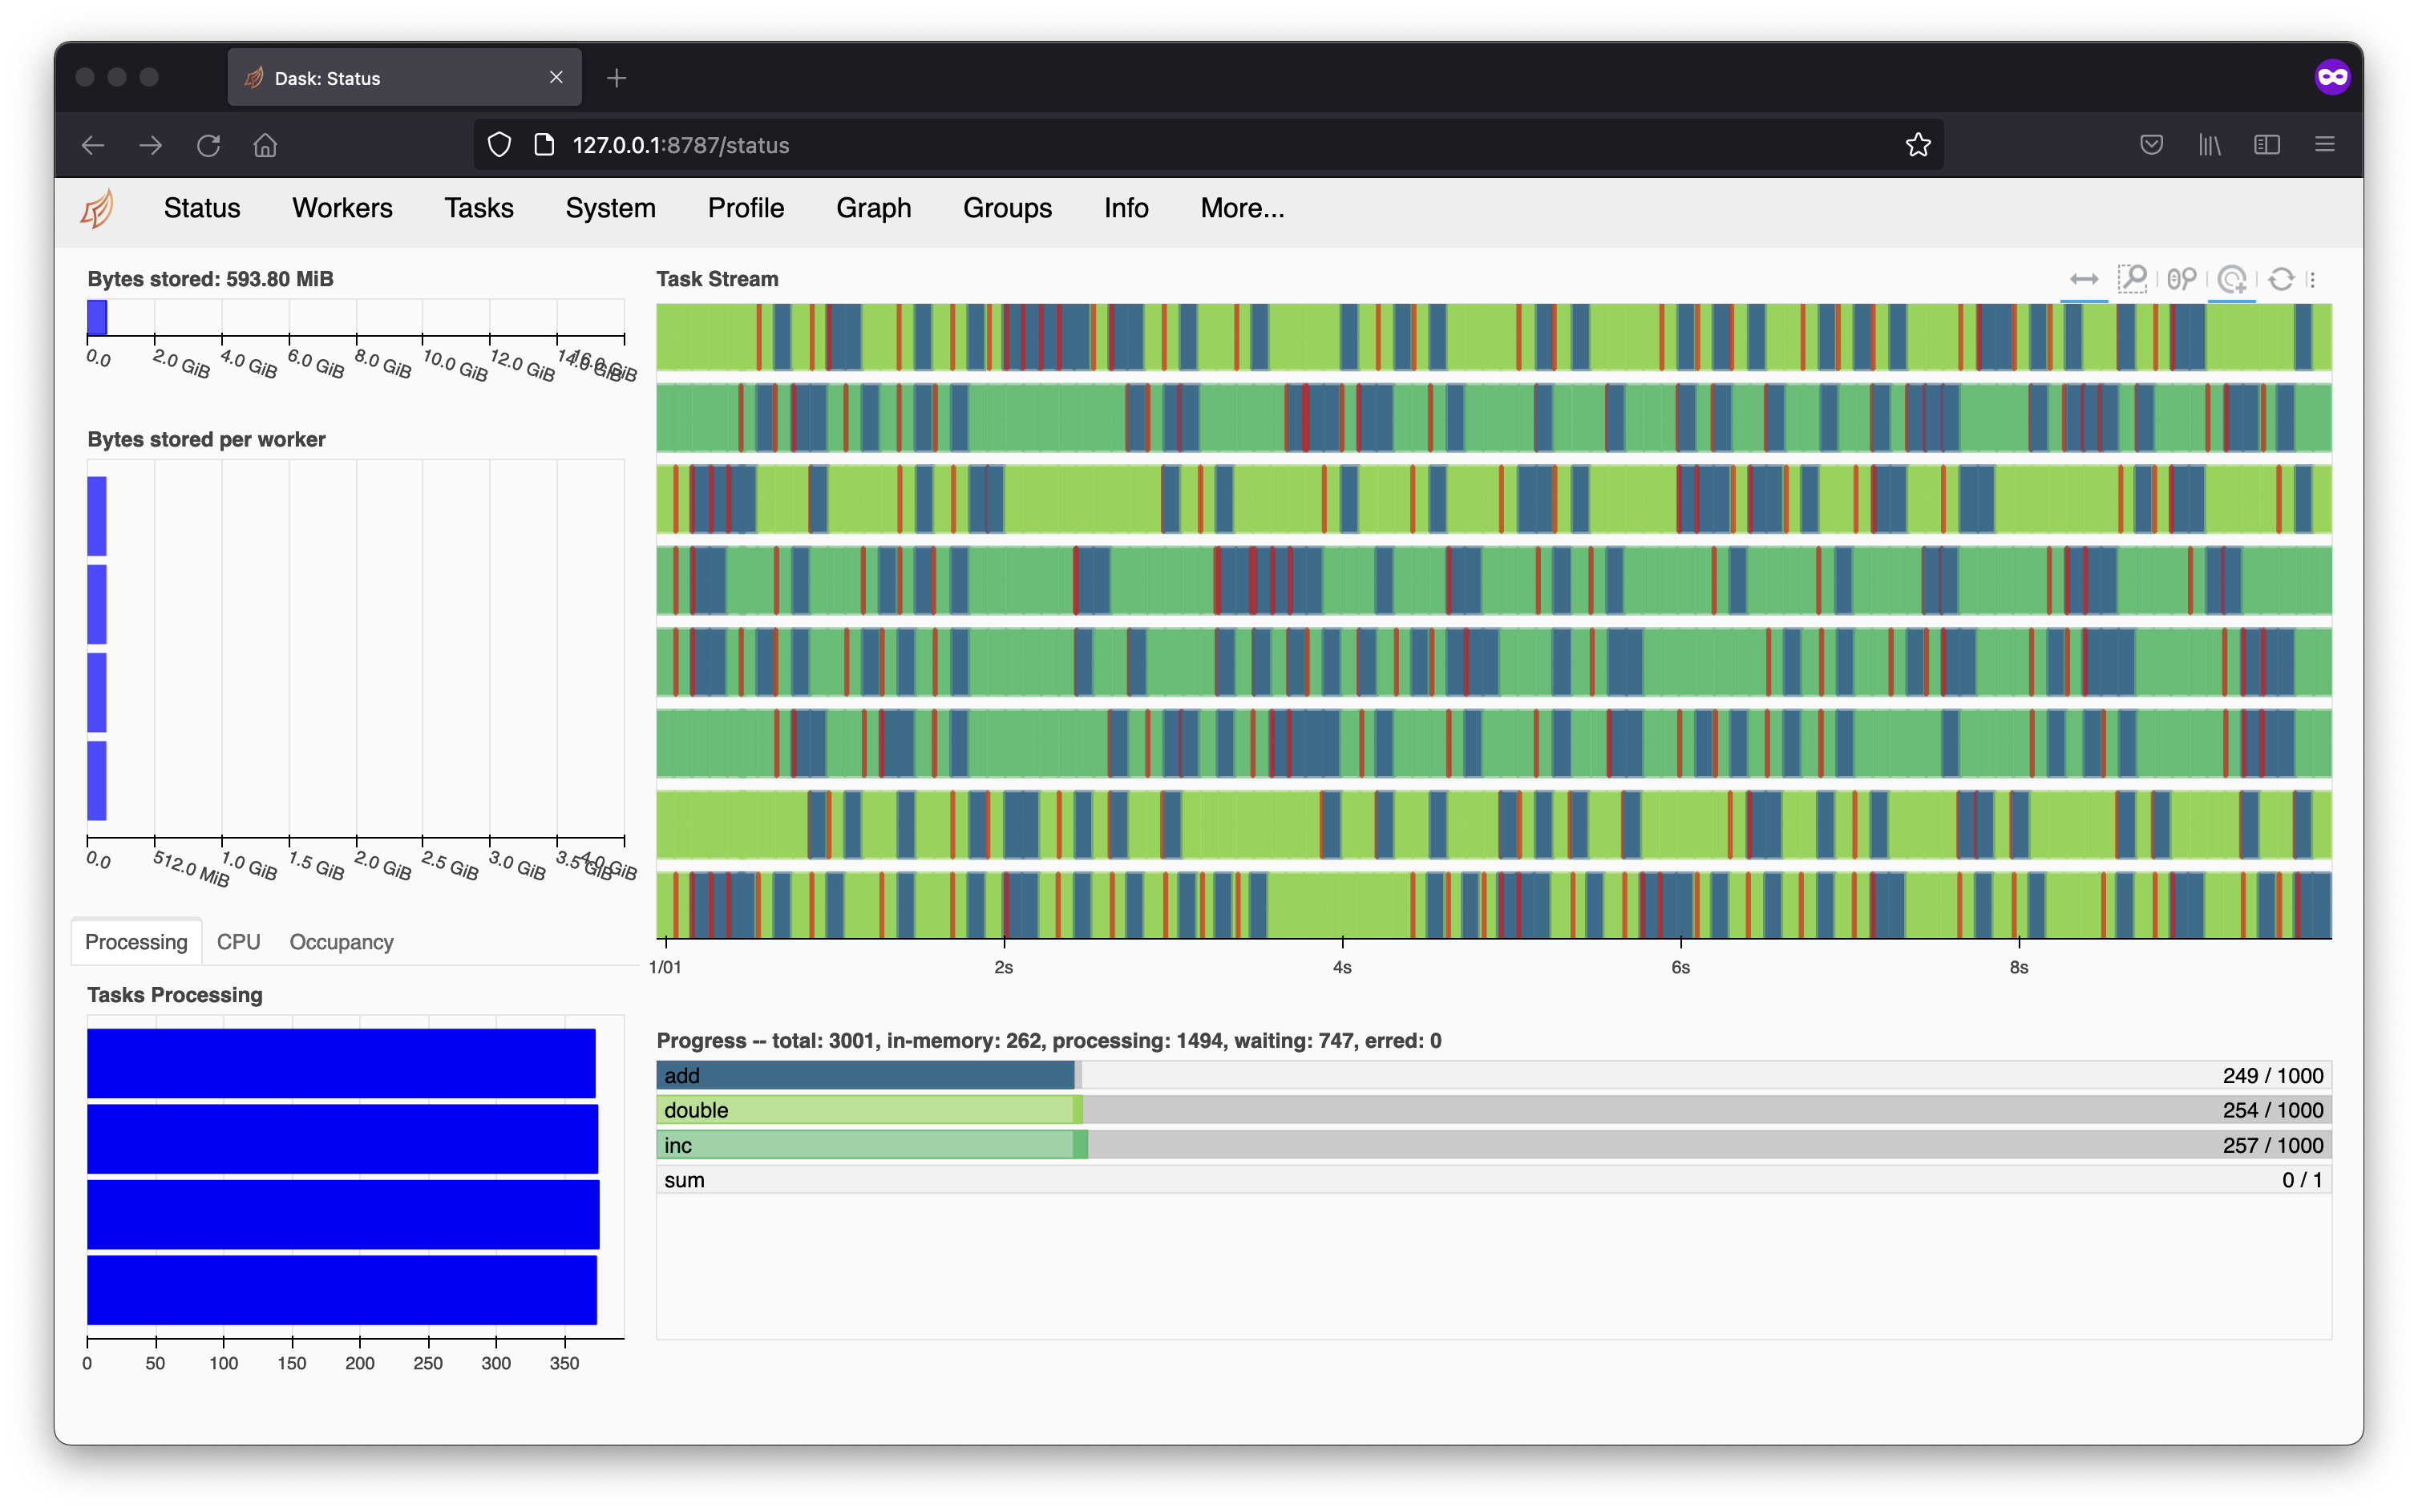

In [28]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [30]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [31]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: total: 203 ms
Wall time: 8.08 s


Before computing: Delayed('sum-0358f024-e308-4294-a6ff-91517e229d72')
After computing : 44
CPU times: total: 703 ms
Wall time: 1.84 s


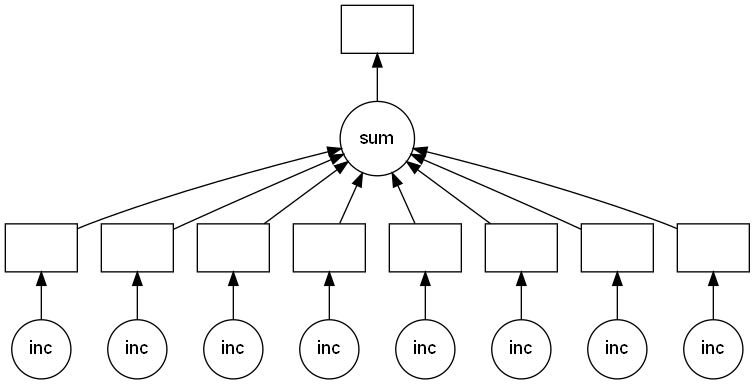

In [33]:
%%time
from dask import delayed
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is

result = total.compute()
print("After computing :", result)  # After it's computed
total.visualize()

# The concurrent.futures interface provides general submission of custom tasks: - [documentation](https://docs.dask.org/en/stable/futures.html)

In [ ]:
from dask.distributed import Client
client = Client('scheduler:port')

futures = []
for fn in filenames:
    future = client.submit(load, fn)
    futures.append(future)

summary = client.submit(summarize, futures)
summary.result()

# Dask-ML [documentation](https://ml.dask.org/)

Dask-ML provides scalable machine learning in Python using Dask alongside popular machine learning libraries like Scikit-Learn, XGBoost, and others.
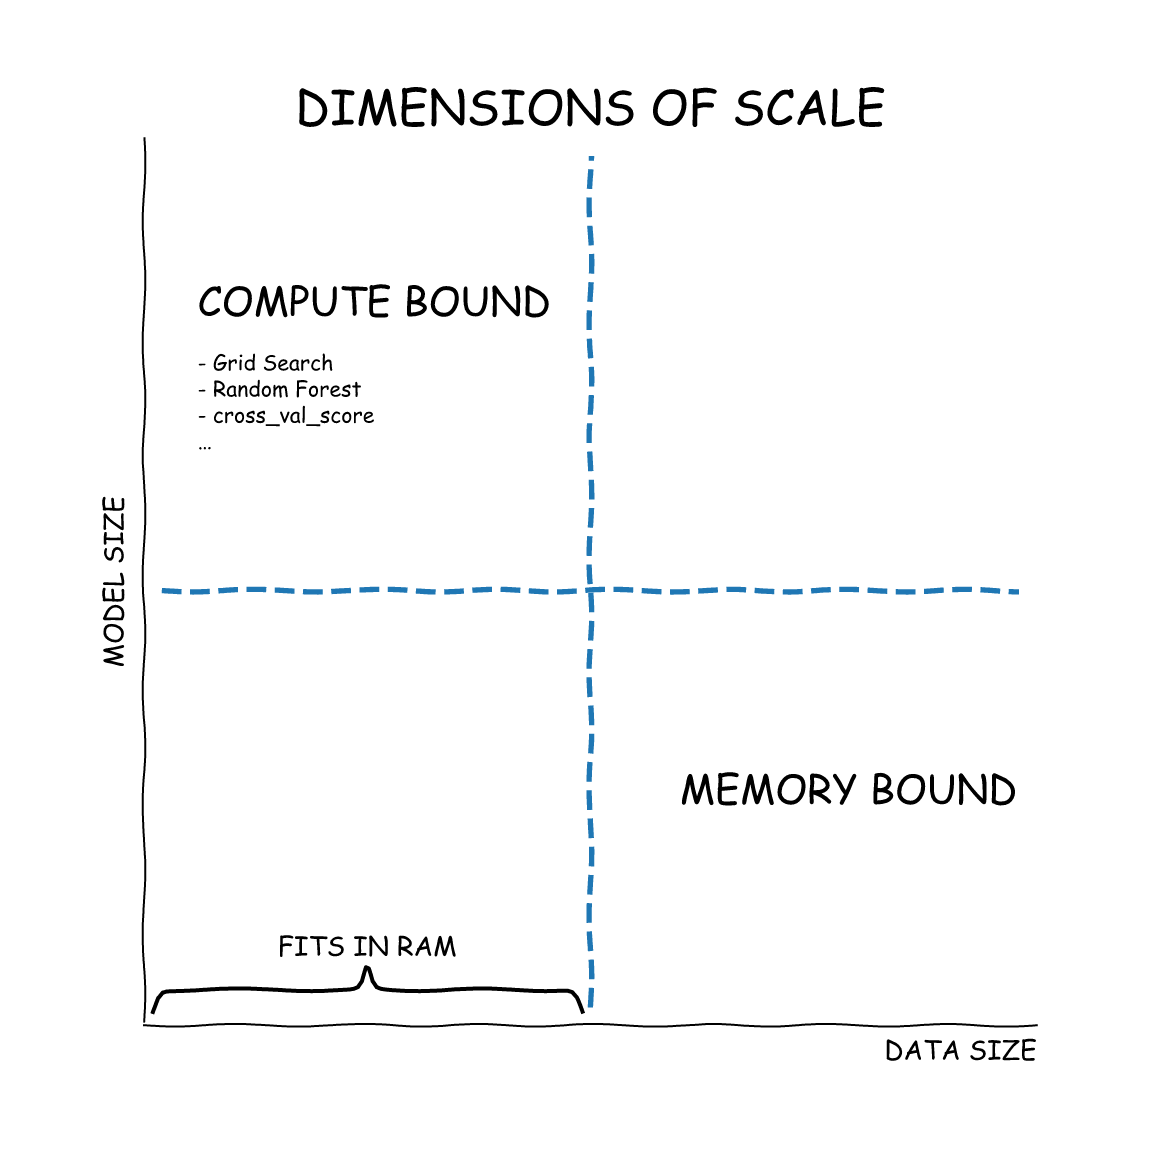
Types of Scaling:

There are a couple of distinct scaling problems you might face. The scaling strategy depends on which problem you're facing.
<ol>
    <li>
CPU-Bound: Data fits in RAM, but training takes too long. Many hyperparameter combinations, a large ensemble of many models, etc.
    </li>
    <li>
Memory-bound: Data is larger than RAM, and sampling isn't an option.
    </li>
    </ol>
<ul>
    <li>
For in-memory problems, just use scikit-learn (or your favorite ML library).
        </li>
    <li>
For large models, use dask_ml.joblib and your favorite scikit-learn estimator
        </li>
    <li>
For large datasets, use dask_ml estimators
        </li>
    </ul>

In [21]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=4, random_state=0)
X[:8]

array([[-0.77244139,  0.3607576 , -2.38110133,  0.08757   ],
       [ 1.14946035,  0.62254594,  0.37302939,  0.45965795],
       [-1.90879217, -1.1602627 , -0.27364545, -0.82766028],
       [-0.77694695,  0.31434299, -2.26231851,  0.06339125],
       [-1.17047054,  0.02212382, -2.17376797, -0.13421976],
       [ 0.79010037,  0.68530624, -0.44740487,  0.44692959],
       [ 1.68616989,  1.6329131 , -1.42072654,  1.04050557],
       [-0.93912893, -1.02270838,  1.10093827, -0.63714432]])

In [22]:

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
estimator = SVC(gamma='auto', random_state=0, probability=True)
param_grid = {
    'C': [0.001, 0.1, 1.0, 2.5, 5, 10.0]
}
grid_search = GridSearchCV(estimator, param_grid, verbose=2, cv=5, n_jobs=-1)


In [23]:
%%time
grid_search.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 54.3 s
Wall time: 3min 4s


GridSearchCV(cv=5,
             estimator=SVC(gamma='auto', probability=True, random_state=0),
             n_jobs=-1, param_grid={'C': [0.001, 0.1, 1.0, 2.5, 5, 10.0]},
             verbose=2)

In [24]:
import joblib
import dask.distributed

c = dask.distributed.Client()
param_grid = {
    'C': [0.001, 0.1, 1.0, 2.5, 5, 10.0]
}

grid_search = GridSearchCV(estimator, param_grid, verbose=2, cv=5, n_jobs=-1)


C:\Users\Rahul\anaconda3\envs\dask-tutorial\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50749 instead
  warnings.warn(


In [25]:
%%time
with joblib.parallel_backend("dask", scatter=[X, y]):
    grid_search.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 57.4 s
Wall time: 3min 2s


In [20]:
grid_search.best_params_, grid_search.best_score_

({'C': 10.0, 'kernel': 'rbf'}, 0.9086000000000001)